# Experimentos numéricos

   Este capítulo é dedicado a alguns experimentos númericos que têm como objetivo visualizar na prática a implementação da técnica Máquinas de Vetores Suporte (SVM), possibilitando assim analisar as particularidades da sua implementação juntamente com o referencial teórico matemático desenvolvido no capítulo anterior. Para tanto, o capítulo é dividido em duas seções. Na primeira, discutimos a aplicação de SVM para classificar o conjunto de dados flor Íris entre suas espécies. A segunda seção aborda a aplicação da técnica CSVM para detectar num conjunto de dados sobre células de câncer de mama quais apresentam tumor maligno ou benigno.

   Para desenvolvimento desses experimentos utilizamos o *software* de programação Julia em sua versão 1.4.0, além dos pacotes ``Plots`` para gerar as imagens, ``JuMP`` e ``Ipopt`` para resolução dos problemas de otimização, ``RDatasets`` para ter acesso ao conjunto de dados Iris e o pacote ``DataFrame`` para gerar as tabelas de dados.
   
   Como abordado no capítulo anterior, Máquinas de Vetores Suporte é uma técnica de Aprendizagem de Máquina muito utilizada para classificação e regressão, e nosso objetivo será sua aplicação em problemas que envolvam a classificação binária de dados. Primeiramente, vamos relembrar que em problemas de classificação estamos interessados, assim como o nome já antecipa, em classificar da melhor maneira possível um determinado conjunto de dados. No caso em que os dados são linearmente separáveis, isto é, existe um hiperplano que os separa corretamente, aplica-se SVM de margem rígida e o problema costuma ter uma resolução mais simples. Entretanto, os problemas de classificação que envolvem situações reais costumam ser mais elaborados, pois neste caso os dados geralmente não são linearmente separáveis. Nestas situações é necessário utilizar SVM com margem flexível (CSVM), se os dados forem, a grosso modo, mais "comportados", ou a SVM não-linear. Este último caso exige um desenvolvimento teórico matemático mais avançado e que foge do escopo deste trabalho e portanto não será abordado, se constituindo numa proposta de estudos a ser desenvolvida em projetos futuros. 

In [117]:
using RDatasets, JuMP, Ipopt, Random, LinearAlgebra, Plots, StatsBase, DataFrames, CSV, StatsPlots
include("pairplot.jl")

pairplot (generic function with 1 method)

## Implementação de SVM para Classificação do Conjunto de Dados Íris

   Neste primeiro momento nosso propósito será implementar a técnica SVM num exemplo prático: o conjunto de dados flor Íris. Tal conjunto de dados consiste em 150 amostras de três espécies da planta Íris, sendo 50 amostras da Íris setosa, 50 da Íris virginica e 50 da Íris versicolor. Cada dado amostral contém as medidas de quatro variáveis morfológicas: comprimento e largura das sépalas e das pétalas, medidas em centímetros. É com base nas diferenciações e semelhanças dessas características que é possível distinguir uma espécie da outra. 
   
   A seguir importamos o conjunto de dados Íris do pacote ``RDatasets``. Perceba que as amostras pertencem a três diferentes espécies: setosa, versicolor e virginica. Porém, como nossos estudos se concentram na classificação binária, nosso objetivo inicial será aprender a separar os dados em setosa e não setosa e posteriormente em virginica e não virginica.

In [2]:
iris = dataset("datasets", "iris")
levels(iris[!,:Species])

3-element Array{String,1}:
 "setosa"
 "versicolor"
 "virginica"

Nos gráficos abaixo, os pontos em azul pertencem à espécie setosa, os pontos em vermelho à espécie versicolor e os pontos em verde à espécie virginica. Eles foram construídos considerando-se duas características de cada vez.

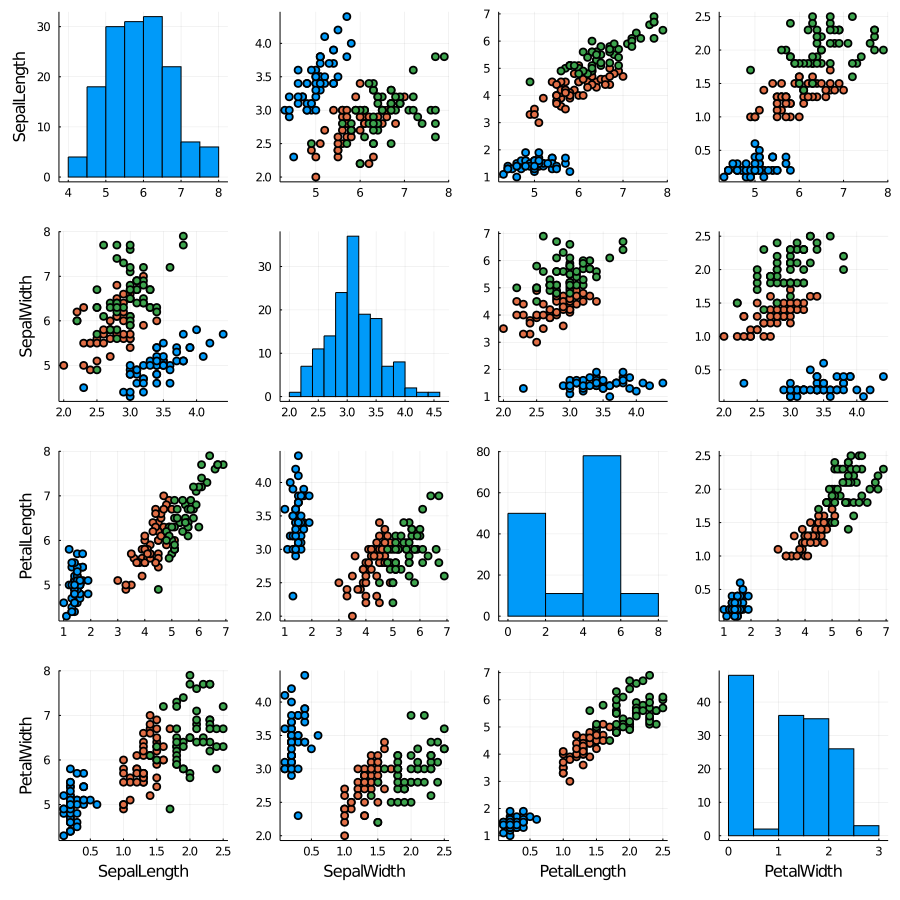

In [118]:
plt = pairplot(iris,:Species)

### Classificação com duas características
   
   De acordo com o Capítulo 5, a técnica SVM com margem rígida pode ser formulada pelo problema (74). Assim, utilizando esta formulação, apresentamos a seguir uma aplicação na classificação do conjunto de dados Íris em setosa e não setosa com base em duas características apenas. 
   
   Inicialmente, é importante lembrar que na modelagem do problema cada dado é representado por um vetor no espaço n-dimensional, em que n corresponde ao número de características do problema em questão. Neste exemplo, como o problema compreende apenas duas características os dados de entrada $x^{i}$ pertencem ao espaço $\mathbb{R}^{2}$. Logo, podemos representar estes dados através de uma matriz $X_{150\times 2}$, em que cada linha corresponde a um vetor $x^{i}$ e cada coluna às suas características, que neste caso serão comprimento e largura das sépalas, medidas em centímetros. 

In [120]:
X = convert(Array,iris[:, 1:2]) 
p, n = size(X)

(150, 2)

   Por conseguinte, a SVM é uma técnica de aprendizagem supervisionada e portanto, a obtenção do classificador é feita com base num conjunto de dados de entrada para os quais há o prévio conhecimento da classe $y_{i}$ a qual cada amostra $i$ pertence. Assim, amostras da espécie setosa serão classificadas como $1$, enquanto que amostras das espécies versicolor ou virginica serão classificadas em $-1$, ou seja, $y_{i} \in \{ -1,1 \}$. 

In [121]:
iris_df = DataFrame(X);
iris_df.Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]];
iris_df.Especie = iris.Species
rename!(iris_df, Dict(:x1 => :Comprimento_sepala))
rename!(iris_df, Dict(:x2 => :Largura_sepala))
first(iris_df, 10);

Portanto, nosso objetivo é classificar o conjunto de dados Íris em setosa e não setosa com base nas características "comprimento de sépala" e "largura de sépala". O gráfico a seguir representa tais dados em relação às duas características citadas. Através dele podemos ter uma noção acerca da separabilidade do conjunto Íris neste contexto.

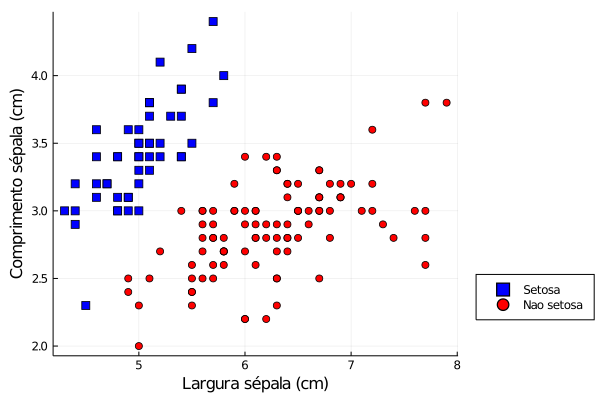

In [122]:
I = findall(iris_df.Y .== 1)
scatter(X[I,1], X[I,2], c=:blue, m=:square, label = "Setosa")
I = findall(iris_df.Y .== -1)
scatter!(X[I,1], X[I,2], c=:red, m=:circle, label = "Nao setosa", legend=:outerbottomright)
plot!(xlabel="Largura sépala (cm)", ylabel="Comprimento sépala (cm)")

Assim, no gráfico acima estão representados os 150 dados do conjunto Íris, em que os pontos em azul representam a espécie setosa, isto é, os vetores $x^{i}$ tais que $y_{i} = 1$, e os pontos em vermelho as espécies versicolor e virginica, que correspondem aos vetores $x^{i}$ tais que $y_{i} = -1$. Como os dados aparentam ser linearmente separáveis, aplicaremos primeiramente SVM com margem rígida.
   
   A aprendizagem supervisionada é composta por dois momentos, a fase de treino e a fase de testes. Em vista disso,  inicialmente dividimos, de maneira aleatória, o conjunto Íris em dois subconjuntos, o conjunto de treinamento (`train_set`), com 50 dados, e o conjunto de teste (`test_set`), com os 100 dados restantes. É através do conjunto de treinamento que o algoritmo SVM irá "aprender" a classificar os dados detectando padrões entre suas características e a espécie a qual pertencem. Já o conjunto de teste será utilizado para analisar a eficácia do classificador encontrado, averiguando se ele gera as saídas corretas para tais dados.  

In [123]:
Random.seed!(0)
trainsize = 50
train_set = sample(1:p,trainsize,replace=false,ordered=true) 
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = iris_df.Y[train_set]
Xtest = X[test_set,:]
Ytest = iris_df.Y[test_set]
ptrain = length(Ytrain)
iris_df.conjunto = fill("treino", p)
iris_df.conjunto[test_set] .= "teste";

   Como abordado no Capítulo 5, a modelagem do problema de classificação utilizando a técnica SVM consiste em determinar o hiperplano que melhor separa os dados, classificando-os assim em duas classes. Ademais, o hiperplano ótimo $\mathcal{H}(w,b)$ é aquele que maximiza a margem que não contenha nenhum dado, ou seja, desejamos que os pontos $x^{i}$ satisfaçam a seguinte restrição

$$
y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 50.
$$

Logo, o problema de encontrar o hiperplano ótimo $\mathcal{H}(w,b)$ é formulado da seguinte forma

\begin{aligned}
\min_{w,b} & \quad \dfrac{1}{2} \Vert w\Vert^{2} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1, \quad i=1, \ldots , 50, 
\end{aligned}

em que, neste exemplo, $w \in \mathbb{R}^{2}$ e $b\in \mathbb{R}$. É importante salientar que como neste caso os dados pertencem ao $\mathbb{R}^{2}$ o hiperplano ótimo será uma reta. 

Assim, utilizando o modelo matemático formulado no capítulo anterior, criamos a função `SVM_rigida`, a qual adapta o problema de otimização formulado em (74) para os dados do problema de classificação que desejamos resolver e, com o auxílio do pacote `Ipopt` para resolver este problema, determina o hiperplano ótimo.

In [124]:
function SVM_rigida(n, ptrain, Xtrain, Ytrain)
    model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

    @variable(model, w[1:n]) # Aqui declaramos as variáveis.
    @variable(model, b)

    @objective(model, Min, dot(w, w) / 2) # Esta é a função objetivo.

    @constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b) ≥ 1) # Esta é a restrição.

    optimize!(model)

    w, b = value.(w), value.(b) # Com este comando queremos que os valores ótimos sejam apresentados.
    return w, b
end
w, b = SVM_rigida(n, ptrain, Xtrain, Ytrain)

([-2.857142829807275, 3.333333301181975], 4.99999995276859)

   Assim, com o auxílio da função `SVM_rigida`, encontramos os valores ótimos para $w$ e $b$, os quais definem o hiperplano separador $\mathcal{H}(w,b)$, que é dado por
   
$$
(-2.857142829807275, 3.333333301181975)^{T} x + 4.99999995276859 = 0,
$$

com $x \in \mathbb{R}^{2}$.
   
   Para melhor visualizar a classificação dos dados de treinamento vamos representá-los graficamente a seguir junto ao hiperplano ótimo.

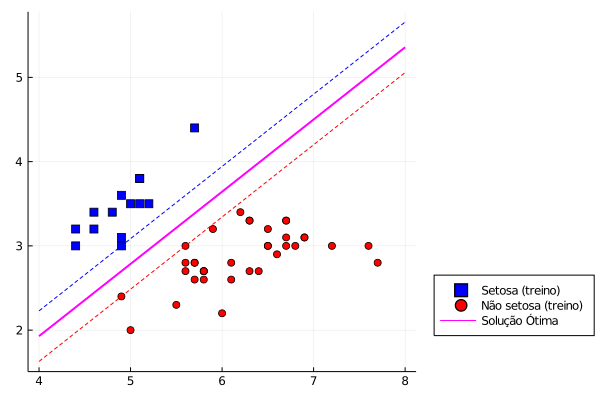

In [125]:
I = findall(Ytrain .== 1)
scatter(Xtrain[I,1], Xtrain[I,2], c=:blue, m=:square, label = "Setosa (treino)", legend=:outerbottomright)
I = findall(Ytrain .== -1)
scatter!(Xtrain[I,1], Xtrain[I,2], c=:red, m=:circle, label = "Não setosa (treino)")
# plot!(leg=false)
plot!(x -> -(w[1] * x + b) / w[2], 4, 8, c=:magenta, lw=:2,label = "Solução Ótima")
plot!(x -> -(w[1] * x + b - 1) / w[2], 4, 8, c=:blue, l=:dash,label = "")
plot!(x -> -(w[1] * x + b + 1) / w[2], 4, 8, c=:red, l=:dash,label = "")

Portanto, no gráfico acima a reta magenta corresponde ao hiperplano ótimo e as retas tracejadas são os hiperplanos que delimitam a máxima margem possível. Observe que o conjuto de dados de treinamento é linearmente separável, pois o hiperplano ótimo os está separando corretamente. 

Além disso, de acordo com a Definição 14 do Capítulo 5.2, temos que os vetores que estão sobre os hiperplanos da margem são os *vetores suporte*. Observe que tais vetores dão suporte ao hiperplano ótimo, de modo que todos os demais vetores poderiam ser descartados sem alterá-lo.

Agora, tendo determinado o classificador (hiperplano ótimo), vamos para a fase de testes, na qual estamos interessados em analisar se o classificador encontrado é eficaz. Para tanto, vamos acrescentar ao gráfico anterior os dados do conjunto de teste e observar se o hiperplano encontrado também os separa corretamente. 

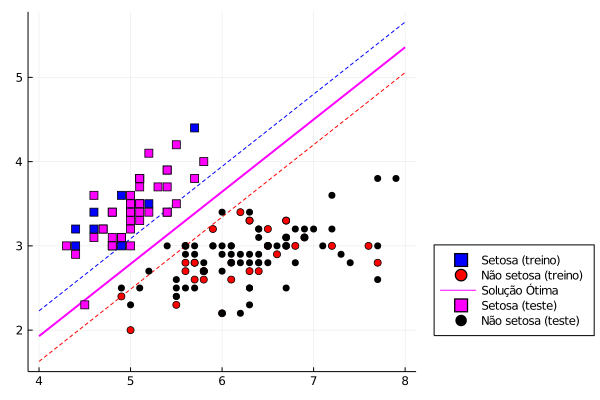

In [126]:
I = findall(Ytest .== 1)
scatter!(Xtest[I,1], Xtest[I,2], c=:magenta, m=:square, label = "Setosa (teste)", legend=:outerbottomright)
I = findall(Ytest .== -1)
scatter!(Xtest[I,1], Xtest[I,2], c=:black, m=:circle, label = "Não setosa (teste)")

Analisando o gráfico acima percebe-se que há um ponto da espécie setosa do conjunto de teste que está localizado ligeiramente do lado direito do hiperplano ótimo, fazendo com que seja classificado incorretamente como não setosa. Assim, como determinar se o classificador encontrado é o melhor?

Para responder a esta pergunta é preciso medir a eficácia do modelo, comparando a real saída dos dados de teste com a respectiva classificação obtida pelo modelo. De modo geral, quanto mais classificações corretas o classificador predizer para o conjunto de teste, mais eficiente ele é. 

Para analisarmos o desempenho do classificador utilizaremos a Matriz de Confusão (REFERENCIAR BIBLIOGRAFIA), também denominada Matriz de Erro, que consiste em uma medida de desempenho muito utilizada para fazer avaliações de modelos de classificação da aprendizagem de máquina supervisionada, como a SVM por exemplo. Ela é uma tabela que apresenta quatro combinações entre a classificação real e a prevista, o que nos permite analisar se a previsão sugerida pelo classificador encontrado ao implementar a SVM é condizente com a verdadeira classificação dos dados. Em síntese, a matriz de confusão apresenta as seguintes frequências: Verdadeiro Positivo (VP), Verdadeiro Negativo (VN), Falso Positivo (FP) e Falso Negativo (FN).

Vamos compreender estas terminologias com base na classificação dos dados Íris. Assim, para o problema em que desejamos classificar amostras em setosa ($y_{i} = 1$) e não setosa ($y_{i} = -1$), temos que

- Verdadeiro Positivo (VP): quantidade de dados que são setosa ($y_{i} = 1$) e foram classificados como tal ($y_{i} = 1$);

- Verdadeiro Negativo (VN): se refere ao número de dados que não são setosa ($y_{i} = -1$) e foram classificados corretamente como não setosa ($y_{i} = -1$);

- Falso Positivo (FP): quantidade de dados não setosa ($y_{i} = -1$) classificados como setosa ($y_{i} = 1$);

- Falso Negativo (FN): quantidade de dados setosa ($y_{i} = 1$) que receberam classificação não setosa ($y_{i} = -1$).

Assim, a matriz de confusão permite observar a relação entre resultados falsos/verdadeiros e negativos/positivos, fornecendo na diagonal principal o número de acertos da classificação predita em relação a real classificação (VP e VN), enquanto os demais elementos correspondem aos erros na classificação (FP e FN). Vale observar que um classificador ideal apresentaria uma matriz de confusão com os elementos não pertencetes a diagonal principal iguais a zero, pois isso significaria que tal classificador não comete erros. 

Ademais, usando os valores fornecidos pela matriz de confusão podemos calcular a acurácia do modelo, que fornece a porcentagem de dados positivos e negativos classificados corretamente. Ela é dada pela seguinte fórmula

$$
\text{Acurácia} = \dfrac{\text{VP} + \text{VN}}{\text{VP} + \text{FP} + \text{VN} + \text{FN}} .
$$

Note que, quanto mais próxima de 1 for a acurácia, mais assertivo é o classificador.

Portanto, para avaliarmos o classificador encontrado, vamos determinar a matriz de confusão para este caso e calcular sua acurácia.

In [127]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)

gdf = filter(:conjunto => x -> x == "teste", iris_df) 
gdf.Ypredito = fill(1., p - ptrain) 
gdf[Nonsetosa, :Ypredito] .= -1

function MatrizConfusao(gdf)
    Verdadeiro_positivo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == 1. && y == 1., gdf)) 
    Verdadeiro_negativo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == -1. && y == -1., gdf))
    Falso_positivo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == -1. && y == 1., gdf))
    Falso_negativo = nrow(filter([:Y, :Ypredito] => (x,y) -> x == 1. && y == -1., gdf))
    
    VP, VN, FP, FN = Verdadeiro_positivo, Verdadeiro_negativo, Falso_positivo, Falso_negativo
    acuracia = (VP + VN)/(VP + FP + VN + FN)
    matrizconfusao = DataFrame(Classe = ["Real Positiva", "Real Negativa"],
                           Predita_Positiva = [VP , FP],
                           Predita_Negativa = [FN, VN] 
                           )
        return  acuracia, matrizconfusao
end
Acuracia_Iris, MatrizConfusao_Iris = MatrizConfusao(gdf);
@show Acuracia_Iris
MatrizConfusao_Iris

Acuracia_Iris = 0.99


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 35               │ 1                │
│ 2   │ Real Negativa │ 0                │ 64               │

A tabela acima corresponde à matriz de confusão para o hiperplano ótimo encontrado, em que dos 100 dados do conjunto de teste, o número de VP = 35, VN = 64, FN = 1 e FP = 0. Ou seja, um dado da espécie setosa foi classificado incorretamente pelo hiperplano ótimo como pertencente às espécies versicolor ou virginica, implicando numa acurácia de 99%. 

É possível visualizar este dado no gráfico apresentado anteriormente e como ele é único analisamos se tal classificação incorreta se repetia nos casos em que a quantidade de dados do conjunto de treinamento fosse maior, averiguando assim se uma maior quantidade de dados para treinar o modelo resultaria numa solução mais eficiente e que classificasse todos os dados de maneira correta. Contudo, o que se observou é que mesmo para um conjunto de treino com 100 dados, por exemplo, ainda ocorria uma classificação incorreta, pois os dados são distribuídos de maneira aleatória entre os conjuntos de treino e teste, de modo que tal controle não seja possível. Ademais, é importante que o conjunto de teste não seja tão pequeno em relação ao conjunto de treino para que não ocorram equívocos ao avaliar se o classificador é bom. 

Em vista disso, aplicamos então a técnica SVM com margem flexível (CSVM) para classificar esse mesmo conjunto de dados Íris e analisar se dessa forma seria possível obter um classificador com uma acurácia de 100% para o conjunto de teste.

Neste caso, de acordo com a teoria desenvolvida no Capítulo 5.3, o problema de classificação com margem flexível tem o seguinte formato

\begin{aligned}
\min_{w,b, \xi} & \quad \dfrac{1}{2} \Vert w\Vert^{2} + C\sum_{i=1}^{50} \xi_{i} \\
\text{s.a.} &  \quad y_i(w^{T}x^{i}+b) \geq 1 - \xi_{i} , \quad i=1, \ldots , 50, \\
& \quad \xi_{i} \geq 0 , \ \ \ \qquad \qquad \qquad i=1, \ldots , 50, 
\end{aligned}

em que $w \in \mathbb{R}^{2}$, $b\in \mathbb{R}$, $\xi \in \mathbb{R}^{50}$ e $C >0$. 

De maneira análoga à função `SVM_rigida`, definimos então a função `SVM_flexivel` com base no problema acima para aplicar aos problemas que exigem a técnica SVM com margem flexível.

In [128]:
function SVM_flexivel(n, ptrain, Xtrain, Ytrain, C = 1.0)
    model = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0))

    @variable(model, w[1:n]) # Aqui declaramos as variáveis.
    @variable(model, b)
    @variable(model, ξ[1:ptrain] ≥ 0)

    @objective(model, Min, dot(w, w) / 2 + C * sum(ξ)) # Esta é a função objetivo.

    @constraint(model, [i=1:ptrain], Ytrain[i] * (dot(w, Xtrain[i,:]) + b)  ≥ 1- ξ[i]) # Esta é a restrição.

    # print(model) 
    optimize!(model)

    w, b, ξ = value.(w), value.(b), value.(ξ) #aqui queremos desenhar os valores ótimos.
        return w, b, ξ
end
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 1.0)

([-1.8054054084207, 1.567567554887953], 4.721081137153712, [0.0, 0.4227026903529496, 0.0, 0.0, 0.0, 0.0, 0.18054053543518253, 0.26594593486415474, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

   Portanto, adaptando nosso modelo obtemos uma nova solução que é apresentada acima. Os valores ótimos encontrados determinaram um novo hiperplano classificador, o qual está representado na cor magenta no gráfico a seguir.
   
   Fazendo uma comparação entre este hiperplano ótimo e aquele determinado no problema em que aplicamos SVM de margem rígida, percebemos que no caso atual os vetores que apresentam $\xi_{i} > 0$ possuem uma maior "liberdade", de modo que possam estar localizados na região entre as margens e o hiperplano separador. Tal "liberdade" é fruto do relaxamento promovido nas restrições através das variáveis de folga, relaxamento que deve ser regulado. É neste contexto que entra o parâmetro $C$. De acordo com Krulikovski (2017), tal parâmetro nos fornece um "equilíbrio entre a maximização da margem e a minimização do erro de classificação". Ou seja,  caso o valor atribuído ao parâmetro de penalização $C$ seja pequeno, uma maior quantidade de vetores recebe folga, inclusive alguns para os quais não seria necessário. Caso contrário, se valores muito altos são atribuídos ao parâmetro $C$, o número de vetores que recebe folga diminui. Contudo, neste último caso o programa tende a se concentrar em minimizar a penalização em vez de maximizar a margem na função objetivo. Em decorrência disso, é de suma importância escolher o valor correto para o parâmetro $C$. 
   
   Assim, ao definir a função `SVM_flexivel` determinamos como padrão $C=1$, pois como veremos na fase de testes tal valor possibilitou uma boa classificação para o problema atual. No entanto, na próxima seção analisaremos os classificadores obtidos para diferentes valores de $C$.

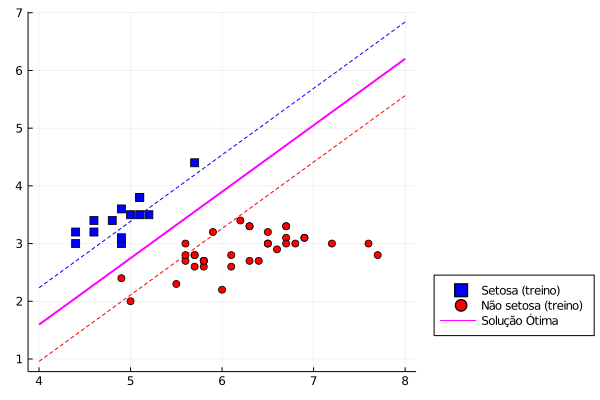

In [129]:
I = findall(ξ .> 1e-6) 
scatter!(Xtrain[I,1], Xtrain[I,2], c=:green, m=(:white, stroke(1,:green), 10))
I = findall(Ytrain .== 1)
scatter(Xtrain[I,1], Xtrain[I,2], c=:blue, m=:square, label = "Setosa (treino)", legend=:outerbottomright)
I = findall(Ytrain .== -1)
scatter!(Xtrain[I,1], Xtrain[I,2], c=:red, m=:circle, label = "Não setosa (treino)")
# plot!(leg=false)
plot!(x -> -(w[1] * x + b) / w[2], 4, 8, c=:magenta, lw=:2,label = "Solução Ótima")
plot!(x -> -(w[1] * x + b - 1) / w[2], 4, 8, c=:blue, l=:dash,label = "")
plot!(x -> -(w[1] * x + b + 1) / w[2], 4, 8, c=:red, l=:dash,label = "")

Novamente, após determinado o classificador, é preciso avaliar sua eficiência. Portanto, utilizando o conjunto de teste vamos construir a matriz de confusão e calcular a acurácia do novo hiperplano encontrado.

In [131]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", iris_df) #filter é uma função. Neste caso, ela foi utilizada para "filtrar"/selecionar em um dataframe que denominamos por "gdf" todos os dados x que possuiam "teste" na coluna "conjunto". Assim, conseguimos analisar a predição do conjunto de teste
gdf.Ypredito = fill(1., p - ptrain) #fill é uma função. Neste caso ela preencheu a coluna Ypredito com 1.
gdf[Nonsetosa, :Ypredito] .= -1
Acuracia_Iris, MatrizConfusao_Iris = MatrizConfusao(gdf);
@show Acuracia_Iris
MatrizConfusao_Iris

Acuracia_Iris = 1.0


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 36               │ 0                │
│ 2   │ Real Negativa │ 0                │ 64               │

Analisando a matriz de confusão temos que os valores de FN e FP são nulos, o que nos permite concluir que o hiperplano ótimo encontrado pela técnica SVM com margem flexível atua como um bom classificador, apresentando uma acurácia igual a 1 e, portanto, 100% de acerto na classificação dos dados de teste em setosa e não setosa. De fato, no gráfico a seguir podemos visualizar que o hiperplano ótimo separa todos os dados dos conjuntos de treino e teste corretamente. 

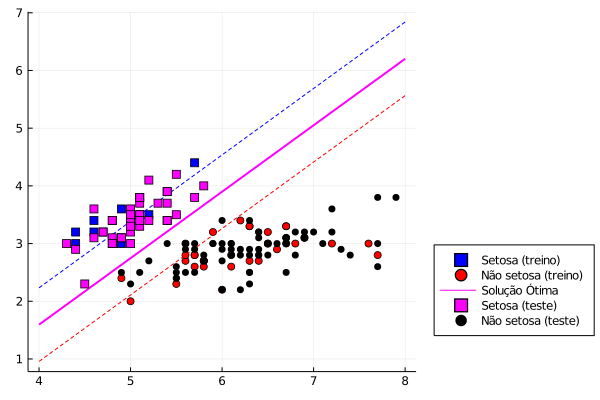

In [132]:
I = findall(Ytest .== 1)
scatter!(Xtest[I,1], Xtest[I,2], c=:magenta, m=:square, label = "Setosa (teste)", legend=:outerbottomright)
I = findall(Ytest .== -1)
scatter!(Xtest[I,1], Xtest[I,2], c=:black, m=:circle, label = "Não setosa (teste)")

Portanto, utilizando a técnica CSVM, com $C = 1$, foi possível determinar um hiperplano separador com uma acurácia de 100% para o conjunto de teste.

### Classificação com quatro características

Agora, vamos analisar a implementação da técnica SVM com margem rígida para a classificação do conjunto de dados Íris em setosa e não setosa levando em consideração quatro características: comprimento e largura das sépalas e pétalas. 

De modo análogo ao exemplo anterior, os dados pertencentes à espécie setosa serão classificados como 1, e os demais, pertencetes às espécies versicolor ou virginica, classificados como -1. A principal diferença agora é que os dados do conjunto de entrada pertencem ao $\mathbb{R}^{4}$.

In [133]:
X = convert(Array,iris[:, 1:4]) 
p, n = size(X)

(150, 4)

In [134]:
iris_df = DataFrame(X);
iris_df.Y = [species == "setosa" ? 1.0 : -1.0 for species in iris[!,:Species]];
iris_df.Especie = iris.Species
rename!(iris_df, Dict(:x1 => :Comp_sepala))
rename!(iris_df, Dict(:x2 => :Larg_sepala))
rename!(iris_df, Dict(:x3 => :Comp_petala))
rename!(iris_df, Dict(:x4 => :Larg_petala))
first(iris_df, 10);

Analisando os gráficos da firgura (referenciar pairplot) temos que os dados setosa (em azul) e não setosa (em verde e vermelho) aparentam ser linearmente separáveis. Guiados por essa perspectiva, vamos aplicar a técnica SVM com margem rígida para determinar o classificador. 

Inicialmente, assim como no problema anterior, é necessário separar os dados Íris em conjunto de treinamento (`train_set`), com 50 dados, e conjunto de teste (`test_set`), com 100 dados.

In [135]:
Random.seed!(0)
trainsize = 50 
train_set = sample(1:p,trainsize,replace=false,ordered=true) 
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = iris_df.Y[train_set]
Xtest = X[test_set,:]
Ytest = iris_df.Y[test_set]
ptrain = length(Ytrain)
iris_df.conjunto = fill("treino", p)
iris_df.conjunto[test_set] .= "teste"
iris_df;

Tendo definido os conjuntos de treino e teste, vamos aplicar a técnica SVM com margem rígida sobre o conjunto de treino para obter o hiperplano separador. Para tanto, utilizaremos a função `SVM_rigida` definida no exemplo anterior.

In [137]:
w, b = SVM_rigida(n, ptrain, Xtrain, Ytrain)

([-1.9124232393354155e-7, 0.32036626873820034, -0.8237985755072652, -0.3661327030904413], 1.3157898999556978)

Agora, vamos avaliar a eficiência do classificador encontrado, isto é, se ele separa os dados corretamente. Para tanto, tomamos o conjunto de teste, para o qual já conhecemos sua real classificação, e comparamos com a classificação predita pelo hiperplano separador. Os resultados desta comparação podem ser visualizados na matriz de confusão dada a seguir e a taxa de acerto é dada pela acurácia..

In [138]:
Setosa = findall(Xtest*w .+ b .>= 0)
Nonsetosa = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", iris_df) 
gdf.Ypredito = fill(1., p - ptrain) 
gdf[Nonsetosa, :Ypredito] .= -1
Acuracia_Iris, MatrizConfusao_Iris = MatrizConfusao(gdf);
@show Acuracia_Iris
MatrizConfusao_Iris

Acuracia_Iris = 1.0


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 36               │ 0                │
│ 2   │ Real Negativa │ 0                │ 64               │

Assim, como os valores da diagonal secundária são todos nulos temos que o hiperplano ótimo separou todos os dados do conjunto de teste corretamente, apresentando uma acurácia de 100%.

Portanto, para o problema que considera as quatro características dos dados amostrais temos que a técnica SVM com margem rígida nos fornece um hiperplano que atua como um bom classificador, separando corretamente todos os dados, tanto de treinamento quanto de teste.

### Classificação em espécie virginica e não virginica utilizando quatro características

Para finalizar os experimentos numéricos com o conjunto de dados Íris, vamos implementar neste momento a técnica SVM com margem flexível para classificar tal conjunto de dados em virginica e não virginica.

Assim como no exemplo anterior, serão consideradas as características comprimento e largura das sépalas e pétalas, de modo que cada vetor $x^{i} \in \mathbb{R}^{4}$. Mas gora, dados da espécie virginica serão classificados com $y_{i} = 1$ e dados das espécies não virginica com $y_{i} = -1$.

In [139]:
X = convert(Array,iris[:, 1:4]) 
p, n = size(X)

(150, 4)

In [140]:
iris_df = DataFrame(X);
iris_df.Y = [species == "virginica" ? 1.0 : -1.0 for species in iris[!,:Species]];
iris_df.Especie = iris.Species
rename!(iris_df, Dict(:x1 => :Comp_sepala))
rename!(iris_df, Dict(:x2 => :Larg_sepala))
rename!(iris_df, Dict(:x3 => :Comp_petala))
rename!(iris_df, Dict(:x4 => :Larg_petala))
first(iris_df,10);

Observando novamente os gráficos apresentados em (referenciar pairplot), é possível perceber que alguns dados pertencentes às duas classes distintas (virginica na cor verde e não virginica nas cores azul e vermelha) acabam se sobrepondo. Logo, intuímos que eles não são linearmente separáveis. Em vista disso, aplicaremos a técnica SVM com margem flexível para obter o classificador. 

De modo análogo ao que foi desenvolvido anteriormente, é necessário primeiramente dividir aleatoriamente o conjunto total de dados em dois subconjuntos: conjunto de treinamento e conjunto de testes. Neste caso, o conjunto de treinamento será composto por 75 dados e o conjunto de teste pelos 75 dados restantes.

In [141]:
Random.seed!(0)
trainsize = 75 
train_set = sample(1:p,trainsize,replace=false,ordered=true)
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = iris_df.Y[train_set]
Xtest = X[test_set,:]
Ytest = iris_df.Y[test_set]
ptrain = length(Ytrain)
iris_df.conjunto = fill("treino", p)
iris_df.conjunto[test_set] .= "teste"
iris_df;

Agora, para obter o hiperplano ótimo aplicamos a função `SVM_flexivel` com parâmetro $C = 1$. 

In [142]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain) 

([-0.34567545524447024, -0.8049690813571304, 1.7254845918550483, 1.6080094600267834], -6.676855229902282, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.8965384097436052, 0.0, 4.7540132568274685e-9, 0.0, 0.0, 0.0, 0.0])

Assim, a solução acima nos fornece o hiperplano ótimo. Observe também que, de acordo com a solução ótima encontrada, algumas variáveis de folga $\xi_{i}$ assumiram valores não nulos. 

Para verificarmos se tal hiperplano atua como um bom classificador recorremos à fase de testes. Em vista disso, apresentamos a seguir a matriz de confusão e a acurácia do hiperplano ótimo encontrado ao classificar o conjunto de teste.. 

In [143]:
Virginica = findall(Xtest*w .+ b .>= 0)
Nonvirginica = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", iris_df) 
gdf.Ypredito = fill(1., p - ptrain) 
gdf[Nonvirginica, :Ypredito] .= -1
Acuracia_Iris, MatrizConfusao_Iris = MatrizConfusao(gdf);
@show Acuracia_Iris
MatrizConfusao_Iris

Acuracia_Iris = 1.0


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 23               │ 0                │
│ 2   │ Real Negativa │ 0                │ 52               │

Felizmente, como a diagonal secundária apresenta somente valores nulos, temos que não ocorreram Falsos Positivos e Falsos Negativos para a classificação do conjunto de teste. Além disso, calculando a acurácia para o conjunto de teste obtemos 100% de acerto. Logo, o hiperplano ótimo encontrado classifica corretamente os dados do conjunto de treino e de teste, se configurando num ótimo classificador.

## Implementação de SVM para Classificação de Dados de Câncer de Mama

   De acordo com o Instituto Nacional de Câncer (INCA), "*Câncer é o nome dado a um conjunto de mais de 100 doenças que têm em comum o crescimento desordenado de células, que invadem tecidos e órgãos. Dividindo-se rapidamente, estas células tendem a ser muito agressivas e incontroláveis, determinando a formação de tumores, que podem espalhar-se para outras regiões do corpo.*" O câncer de mama por sua vez ocorre quando há formação de tumor na mama, sendo o tipo de câncer mais incidente entre as mulheres, tanto no Brasil quanto no mundo. No mundo, somente em 2018, foram registrados cerca de 2,1 milhões de novos casos, número que equivale a 11,6% de todos os cânceres estimados. No Brasil, em 2017, ocorreram 16.724 óbitos por câncer de mama e, segundo estimativas do INCA,  são estimados cerca de 66.280 novos casos de câncer de mama no Brasil para cada ano do triênio 2020-2022, o que correponde a uma taxa de incidência de 61,61 novos casos a cada 100 mil mulheres. 
   
   O diagnóstico precoce é um dos principais fatores que contribuem para reduzir a mortalidade por câncer, possibilitando cerca de 95% de chances de cura. Neste contexto, "*A mamografia é uma das melhores técnicas para o rastreamento do câncer de mama disponível atualmente, capaz de registrar imagens da mama com a finalidade de diagnosticar a presença ou ausência de estruturas que possam indicar a doença. Com esse tipo de exame pode-se detectar o tumor antes que ele se torne palpável.*" (LEAL, LIMA e SILVA, 2019). 
   Tendo em vista as altas taxas de incidência e mortes causadas pelo câncer de mama, muitas pesquisas científicas vem sendo desenvolvidas nos últimos anos com o intuito de auxiliar no diagnósticos de doenças, tornando as técnicas de aprendizagem de máquina cada vez mais presentes na área médica. 
   
   Visto que este tema é de grande relevância e interesse, o próximo experimento numérico será realizado com um conjunto de dados sobre células de câncer de mama retirados do *UC Irvine Machine Learning Repository*. Nosso objetivo será utilizar a técnica SVM com margem flexível para classificar estes dados em tumores malignos ou benignos. 
   
   Este conjunto é composto por 569 dados, em que cada um possui um número de identidade (ID), sua classificação em tumor maligno (M) ou benigno (B) e 30 características acerca de núcleos celulares presentes em imagens digitalizadas de um aspirado por agulha fina (do inglês *fine needle aspirate*, FNA), de uma massa mamária. As características extraídas dos núcleos celulares são:
   
- Raio (média das distâncias do centro aos pontos do perímetro);

- Textura (desvio padrão dos valores da escala cinza); 

- Perímetro;

- Área;

- Suavidade (variação local nos comprimentos do raio);

- Compactação ($\dfrac{\text{perímetro}^{2}}{\text{área} - 1.0}$);

- Concavidade (severidade das porções côncavas do contorno);

- Pontos côncavos (número de partes côncavas do contorno);

- Simetria;

- Dimensão fractal ("aproximação da costa" - 1).

Para cada imagem foram calculadas a média, o desvido padrão e o "pior" ou maior (média dos três maiores valores) dos valores atribuídos a cada um dos atributos acima mencionados, resultando nas 30 características da tabela a seguir. 

In [144]:
col_headers = ["id" ,"diagnosis" ,"radius_mean" ,"texture_mean" ,"perimeter_mean" ,"area_mean" ,"smoothness_mean" ,"compactness_mean" ,"concavity_mean" ,"concave points_mean" ,"symmetry_mean" ,"fractal_dimension_mean" ,"radius_se" ,"texture_se" ,"perimeter_se" ,"area_se" ,"smoothness_se" ,"compactness_se" ,"concavity_se" ,"concave points_se" ,"symmetry_se" ,"fractal_dimension_se" ,"radius_worst" ,"texture_worst" ,"perimeter_worst" ,"area_worst" ,"smoothness_worst" ,"compactness_worst" ,"concavity_worst" ,"concave points_worst" ,"symmetry_worst" ,"fractal_dimension_worst"]
cancer_df = CSV.read("cancer_data.csv", header = col_headers,)
cancer_df.Y = [diagnosis == "M" ? 1.0 : -1.0 for diagnosis in cancer_df[!,:diagnosis]];
first(cancer_df,10) 

10×33 DataFrame. Omitted printing of 28 columns
│ Row │ id       │ diagnosis │ radius_mean │ texture_mean │ perimeter_mean │
│     │ Int64    │ String    │ Float64     │ Float64      │ Float64        │
├─────┼──────────┼───────────┼─────────────┼──────────────┼────────────────┤
│ 1   │ 842302   │ M         │ 17.99       │ 10.38        │ 122.8          │
│ 2   │ 842517   │ M         │ 20.57       │ 17.77        │ 132.9          │
│ 3   │ 84300903 │ M         │ 19.69       │ 21.25        │ 130.0          │
│ 4   │ 84348301 │ M         │ 11.42       │ 20.38        │ 77.58          │
│ 5   │ 84358402 │ M         │ 20.29       │ 14.34        │ 135.1          │
│ 6   │ 843786   │ M         │ 12.45       │ 15.7         │ 82.57          │
│ 7   │ 844359   │ M         │ 18.25       │ 19.98        │ 119.6          │
│ 8   │ 84458202 │ M         │ 13.71       │ 20.83        │ 90.2           │
│ 9   │ 844981   │ M         │ 13.0        │ 21.82        │ 87.5           │
│ 10  │ 84501001 │ M         │ 12.46       │ 24.04        │ 83.97          │

A seguir temos a representação gráfica destes dados considerando-se algumas das características mencionadas. Nestes gráficos, os pontos em azul correspondem aos dados que pertencem à classe benigna e os dados em vermelho à classe maligna.

In [119]:
plt1 = pairplot(select(cancer_df,2:7),:diagnosis)

In [145]:
X = convert(Array,cancer_df[:, 3:32]) 
p, n = size(X)

(569, 30)

Neste exemplo, cada dado $x^{i}$ do conjunto de entrada pertence ao $\mathbb{R}^{30}$, pois são 30 as características. Ademais, os dados diagnosticados como malignos (M) serão classificados como $y_{i} = 1$, e os dados com diagnóstico benigno serão classificados com $y_{i} = -1$.  

Com base nos gráficos apresentados anteriormente em (referenciar pairplot), em que apenas duas características foram consideradas em cada vez, é possível intuir que os dados não são linearmente separáveis. Em vista disso, vamos aplicar a técnica SVM com margem flexível para classificar os dados deste conjunto em câncer Maligno ou Benigno e então discutir os resultados encontrados.

Dos 569 dados do conjunto de entrada, 150 dados foram direcionados ao conjunto de treinamento e os 419 restantes ao conjunto de teste.

In [146]:
Random.seed!(0)
trainsize = 150 
train_set = sample(1:p,trainsize,replace=false,ordered=true) 
test_set = setdiff(1:p,train_set) 
Xtrain = X[train_set,:]
Ytrain = cancer_df.Y[train_set]
Xtest = X[test_set,:]
Ytest = cancer_df.Y[test_set]
ptrain = length(Ytrain)
cancer_df.conjunto = fill("treino", p)
cancer_df.conjunto[test_set] .= "teste"
cancer_df;

Utilizando a função `SVM_flexivel` criada com base na modelagem matemática desenvolvida no Capítulo 5.3, determinamos o hiperplano ótimo para os seguintes valores para o parâmetro $C$: $10^{-3}, 10^{-2}, 10^{-1} , 1, 10, 10^{2}, 10^{3}$ e $10^{4}$. Para cada solução encontrada, apresentamos a matriz de confusão e a acurácia da classificação do conjunto de teste.

In [147]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e-4)

([-0.0007584283177882137, 0.024749817454506762, 0.00982209482712832, -0.011282507259653917, 0.00013295432105445856, 0.0004154898251251025, 0.0006312360235894731, 0.00024384420872600586, 0.00027601134019575573, 4.665038877030032e-5  …  0.0005756889944850092, 0.04619250214325389, 0.02472436756707939, 0.011565605684616734, 0.0002859685759089532, 0.001235906582027093, 0.0014209902266727214, 0.0005180570571382942, 0.0006807587758263872, 0.00016070250122321423], -8.404759750812232, [2.4959040020823604e-6, 2.4959043618068177e-6, 2.4959125710341423e-6, 1.9276303108231698, 2.495903935099459e-6, 2.495903905883532e-6, 2.495906246322224e-6, 1.2613350516644837, 2.495907890741903e-6, 2.495316494429242e-6  …  2.4959045392905032e-6, 2.4959056896043816e-6, 0.19402238303058814, 2.495905519516858e-6, 2.4959053464691815e-6, 2.4959096108090774e-6, 2.4959059689534183e-6, 2.4959053893703745e-6, 2.4959101157029523e-6, 2.518615174704158e-6])

In [151]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
Acuracia_Cancer1, MatrizConfusao_Cancer = MatrizConfusao(gdf);
@show Acuracia_Cancer1
MatrizConfusao_Cancer

Acuracia_Cancer1 = 0.9284009546539379


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 134              │ 26               │
│ 2   │ Real Negativa │ 4                │ 255              │

In [152]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e-3)

([-0.008071834546164055, 0.02964516170483992, 0.05439311212608333, -0.011592597530669197, 0.0010117589836746482, 0.003059179554266445, 0.00469094216762709, 0.0018313777890004742, 0.0023394131861448463, 0.0003206848554581697  …  0.0008173819959716312, 0.07826525542595351, 0.09129580035638003, 0.005833410145061603, 0.0020906762524775875, 0.008699190259215589, 0.01033383513687236, 0.00356457271058732, 0.00579540977912883, 0.0009855438257824088], -15.648973824054996, [8.090908928375011e-8, 8.090908690357927e-8, 8.090902577159512e-8, 1.5151717982985544, 8.090908937916708e-8, 8.090908950356853e-8, 8.090908229597614e-8, 1.1277075000492554, 8.090908126371524e-8, 1.2533920792608306e-7  …  8.090908705997125e-8, 8.090908560549803e-8, 8.090894497521895e-8, 8.090908643441776e-8, 8.090908688233132e-8, 8.090906837019454e-8, 8.090908456189375e-8, 8.090908662184402e-8, 8.090895727226532e-8, 0.30469823356286746])

In [153]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
Acuracia_Cancer2, MatrizConfusao_Cancer = MatrizConfusao(gdf);
@show Acuracia_Cancer2
MatrizConfusao_Cancer

Acuracia_Cancer2 = 0.9451073985680191


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 143              │ 17               │
│ 2   │ Real Negativa │ 6                │ 253              │

In [154]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e-2)

([-0.08883859935941509, -0.0007301764450351338, 0.11196686858229796, -0.015880476369110896, 0.0077308924966434265, 0.01828321056890381, 0.0318465212114556, 0.012830609393021945, 0.019070023730440845, 0.0014135096052743143  …  -0.02053124086571956, 0.1513050861013803, 0.1628249854452688, 0.0029656267819460325, 0.015498496314976528, 0.05406193808794602, 0.06897533125709296, 0.02420806592934625, 0.05046217998632266, 0.004051358075620132], -23.616685170113474, [1.5059034230248166e-8, 1.505902784015334e-8, 1.5059013504676282e-8, 1.4993461320183339, 1.5059034010093344e-8, 1.5059034338182133e-8, 1.505902765553629e-8, 0.8223470172586017, 1.5059027661030145e-8, 3.245062406322502e-8  …  1.5059030618342077e-8, 1.5059031346579448e-8, 1.505898282181878e-8, 1.505903210903274e-8, 1.505903246813715e-8, 1.5059015417531872e-8, 1.505903027745674e-8, 1.5059032227815374e-8, 1.5057894542135392e-8, 0.3697295777511198])

In [155]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
Acuracia_Cancer3, MatrizConfusao_Cancer = MatrizConfusao(gdf);
@show Acuracia_Cancer3
MatrizConfusao_Cancer

Acuracia_Cancer3 = 0.9474940334128878


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 144              │ 16               │
│ 2   │ Real Negativa │ 6                │ 253              │

In [156]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 1.0)

([-0.7729017246884566, -0.1406586374058212, 0.32841352824399955, -0.023165676695901805, 0.06467371096380553, 0.14063135523300005, 0.2613983556131847, 0.10085914480945476, 0.15929257739876423, 0.008169698828665002  …  -0.2061791916413598, 0.3305765154420947, 0.18364189309897802, 0.006979634425618434, 0.12293945576818568, 0.44567730493780655, 0.531464519993343, 0.1782847893344932, 0.4722469677605428, 0.030492652655000313], -33.343409789212245, [0.0, 0.0, 0.0, 1.1737976617238983, 0.0, 0.0, 0.0, 0.2866762387701526, 0.0, 7.891659837529961e-9  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [157]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
Acuracia_Cancer4, MatrizConfusao_Cancer = MatrizConfusao(gdf);
@show Acuracia_Cancer4
MatrizConfusao_Cancer

Acuracia_Cancer4 = 0.954653937947494


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 151              │ 9                │
│ 2   │ Real Negativa │ 10               │ 249              │

In [158]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10)

([-3.6487762436326836, -0.29959521673733175, 0.5274961875892948, 0.001283865955048474, 0.31330786463628163, 0.6543943804337382, 1.0338805180518638, 0.4276064986495521, 0.9735932658298027, -0.006822715279178024  …  -1.5067614807593293, 0.5207062274097332, 0.0813400268574002, 0.018028717775124402, 0.7427837309049162, 1.2626847689039904, 1.7414994379042148, 1.0445809691645298, 2.970881403107341, 0.044847280662490115], -4.738710351251095, [0.0, 0.0, 0.0, 0.6794234691449967, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [159]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
Acuracia_Cancer5, MatrizConfusao_Cancer = MatrizConfusao(gdf);
@show Acuracia_Cancer5
MatrizConfusao_Cancer

Acuracia_Cancer5 = 0.9618138424821002


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 153              │ 7                │
│ 2   │ Real Negativa │ 9                │ 250              │

In [160]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e1)

([-10.399808449871205, -0.590006114736005, 0.7872795210500593, 0.06187996412575694, 2.057026937218037, 2.0193520960025944, 3.682512601056333, 2.021390702696653, 2.0444537638029106, -0.4367825977363267  …  2.0273995465503107, 1.0936450397666235, 0.34796969753878976, -0.039436117524285455, 3.552870535914451, 1.1156727117988623, -0.6844515145652738, 2.3460191468328087, 6.112286759070949, -0.907583497535001], -16.708195506555544, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [108]:
norm(ξ)

0.0

In [161]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
Acuracia_Cancer6, MatrizConfusao_Cancer = MatrizConfusao(gdf);
@show Acuracia_Cancer6
MatrizConfusao_Cancer

Acuracia_Cancer6 = 0.954653937947494


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 150              │ 10               │
│ 2   │ Real Negativa │ 9                │ 250              │

In [167]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e2)

([-11.728964719304864, -0.6531286380075404, 0.7857005039636233, 0.07695537025813765, 2.3008892175891917, 2.263952420402395, 4.165137374759006, 2.301228551624926, 2.2592551232672107, -0.5087724179919326  …  2.7732654840040873, 1.2189973849578957, 0.4555928575164663, -0.05457501150167875, 3.9712797002793803, 1.0295346824208211, -1.036891270048293, 2.6204037204964297, 6.953967977313699, -1.0591624084845783], -20.128105044575477, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [168]:
norm(ξ)

0.0

In [163]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
Acuracia_Cancer7, MatrizConfusao_Cancer = MatrizConfusao(gdf);
@show Acuracia_Cancer7
MatrizConfusao_Cancer

Acuracia_Cancer7 = 0.9522673031026253


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 149              │ 11               │
│ 2   │ Real Negativa │ 9                │ 250              │

In [169]:
w, b, ξ = SVM_flexivel(n, ptrain, Xtrain, Ytrain, 10e3)

([-11.728964150295528, -0.6531283956251783, 0.7857003945369919, 0.07695536854528752, 2.30088867859325, 2.2639527719715957, 4.165137969194577, 2.3012284565415655, 2.25925504923999, -0.5087721011621547  …  2.773266565376222, 1.2189972289698123, 0.4555928463105921, -0.05457501831399952, 3.971279019697429, 1.0295369295765158, -1.0368898026407656, 2.620402760011636, 6.953970370774817, -1.0591615387820736], -20.128115472988423, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [170]:
norm(ξ)

0.0

In [112]:
norm(w3-w2)

4.274391744439344e-6

In [165]:
Maligno = findall(Xtest*w .+ b .>= 0)
Benigno = findall(Xtest*w .+ b .< 0)
gdf = filter(:conjunto => x -> x == "teste", cancer_df) 
gdf.Ypredito = fill(1., p - ptrain)
gdf[Benigno, :Ypredito] .= -1
Acuracia_Cancer8, MatrizConfusao_Cancer = MatrizConfusao(gdf);
@show Acuracia_Cancer8
MatrizConfusao_Cancer

Acuracia_Cancer8 = 0.9522673031026253


2×3 DataFrame
│ Row │ Classe        │ Predita_Positiva │ Predita_Negativa │
│     │ String        │ Int64            │ Int64            │
├─────┼───────────────┼──────────────────┼──────────────────┤
│ 1   │ Real Positiva │ 149              │ 11               │
│ 2   │ Real Negativa │ 9                │ 250              │

In [166]:
Resultados = DataFrame(C = [10e-4 , 10e-3, 10e-2 , 1, 10, 10e1, 10e2, 10e3],
                           Acurácia = [Acuracia_Cancer1, Acuracia_Cancer2, Acuracia_Cancer3, 
                                       Acuracia_Cancer4, Acuracia_Cancer5, Acuracia_Cancer6, 
                                       Acuracia_Cancer7, Acuracia_Cancer8] 
                           ) 

8×2 DataFrame
│ Row │ C       │ Acurácia │
│     │ Float64 │ Float64  │
├─────┼─────────┼──────────┤
│ 1   │ 0.001   │ 0.928401 │
│ 2   │ 0.01    │ 0.945107 │
│ 3   │ 0.1     │ 0.947494 │
│ 4   │ 1.0     │ 0.954654 │
│ 5   │ 10.0    │ 0.961814 │
│ 6   │ 100.0   │ 0.954654 │
│ 7   │ 1000.0  │ 0.952267 │
│ 8   │ 10000.0 │ 0.952267 │

Observe que, conforme diferentes valores são atribuídos ao parâmetro $C$ a solução ótima também varia, porém nenhuma delas apresenta 100% de acerto na classificação dos dados de teste. Em vista disso, para escolhermos o melhor hiperplano classificador dentre os hiperplanos calculados, é necessário analisar qual é o mais eficiente. Para realizar essa escolha é preciso compreender que no contexto do nosso problema o classificador que desejamos obter fornecerá o diagnóstico de câncer de mama em maligno ou benigno. Desse modo, além de possuir uma alta acurácia, é de suma importância que o classificador apresente uma baixa quantidade de falsos negativos, pois neste caso uma pessoa com câncer maligno receberia um diagnóstico benigno, comprometendo seu tratamento médico. 

Assim, a tabela "Resultados" acima apresenta na primeira coluna os diferentes valores atribuídos ao parâmetro $C$ e, na segunda coluna, a respectiva acurácia na classificação dos dados de teste pelo hiperplano ótimo encontrado em cada caso. 

Primeiramente, analisando as soluções ótimas encotradas, notamos que conforme o parâmetro $C$ aumenta, a quantidade de variáveis de folga não nulas diminui. Isso também implica que quanto maior o parâmetro $C$, maior é a penalização sobre as variáveis de folga e, portanto, menor a margem de separação. Tanto é que a partir de $C$ próximo a 100 as variáveis de folga passam a ser todas nulas, pois neste caso temos $\Vert \xi \Vert = 0$, e o problema assume a formulação da técnica SVM com margem rígida. 

Por conseguinte, com base na tabela "Resultados", os parâmetros $C = 10^{3}$ e $C = 10^{4}$ apresentam a mesma acurácia de 95,22%, sugerindo que as soluções encontradas são muito próximas. Com efeito, calculando a norma da diferença entre a solução $w$ encontrada para cada um desses parâmetros obtemos um valor muito pequeno. 

Por fim, temos que o parâmetro $C = 10$ determina a solução com maior acurácia, 96,18%, e menor quantidade de falsos negativos, que totalizam 7. Enquanto que para as demais soluções a acurácia varia entre 92,84% e 95,46% e a quantidade de falsos negativos fica entre 9 e 26. Portanto, tomando $C = 10$ temos, dentre as escolhas de $C$, o classificador que fornece o melhor diagnóstico para os dados de câncer.

# Referências
Sites usados para obter estimativas dados de câncer e referenciar:
- https://www.sbmastologia.com.br/noticias/inca-lanca-estimativa-da-incidencia-de-cancer-de-mama-no-brasil/
- https://www.inca.gov.br/tipos-de-cancer/cancer-de-mama
- https://www.femama.org.br/2018/br/noticia/o-cancer-de-mama-em-numeros

Trabalhos que abordam a aplicação de SVM em dados de câncer de mama:
- https://fei.edu.br/~cet/AlbertXavier_WVC2011.pdf
- https://www.scielo.br/pdf/tema/v20n2/2179-8451-tema-20-02-229.pdf (LEAL, LIMA e SILVA, 2019).

Conjunto de dados câncer de mama retirados de:
- https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)
Citar como: Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. - já acrescentado no bibtext.
- http://pages.cs.wisc.edu/~olvi/uwmp/cancer.html